## 모듈 임포트

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest
from scipy.stats import ttest_1samp

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

- 바이낸스 데이터 불러오기

In [2]:
binance_2022 = pd.read_csv('DATA/Binance_2022.csv')
binance_2023 = pd.read_csv('DATA/Binance_2023.csv')

In [3]:
binance_2022['Open time'] = pd.to_datetime(binance_2022['Open time'])
binance_2023['Open time'] = pd.to_datetime(binance_2023['Open time'])

- 업비트 데이터 불러오기

In [4]:
upbit_2022 = pd.read_csv('DATA/upbit_2022_krw_BTC.csv')
upbit_2023 = pd.read_csv('DATA/upbit_2023_krw_BTC.csv')

In [5]:
upbit_2022['datetime'] = pd.to_datetime(upbit_2022['candle_date_time_utc']) # 미국 시간 기준
upbit_2023['datetime'] = pd.to_datetime(upbit_2023['candle_date_time_utc'])

- 환율 데이터 가져오기

In [6]:
money_2022 = pd.read_csv('DATA/환율_2022.csv')
money_2023 = pd.read_csv('DATA/환율_2023.csv')

## 바이낸스 데이터 원화로 변경

In [7]:
# 바이낸스 데이터 원화로 변경하여 추출
def binance_to_KRW(binance, money):
    binance_adjust = binance[['Open time', 'Close']].rename(columns={'Open time': 'datetime'})
    binance_adjust['일자'] = binance_adjust['datetime'].dt.strftime('%Y.%m.%d')
    
    binance_merged = binance_adjust.merge(money, on='일자', how='left')
    
    binance_merged['Binance_won'] = binance_merged['Close'] * binance_merged['기준환율']
    binance_merged = binance_merged[['datetime', 'Binance_won']]
    
    return binance_merged

In [8]:
binance_2022_won = binance_to_KRW(binance_2022, money_2022)
binance_2022_won.head()

,datetime,Binance_won
0,2022-01-01 00:00:00,5.491395e+07
1,2022-01-01 00:05:00,5.497295e+07
2,2022-01-01 00:10:00,5.492719e+07
3,2022-01-01 00:15:00,5.488142e+07
4,2022-01-01 00:20:00,5.500190e+07


In [9]:
binance_2023_won = binance_to_KRW(binance_2023, money_2023)
binance_2023_won.head()

,datetime,Binance_won
0,2023-01-01 00:00:00,2.095529e+07
1,2023-01-01 00:05:00,2.094425e+07
2,2023-01-01 00:10:00,2.093667e+07
3,2023-01-01 00:15:00,2.095473e+07
4,2023-01-01 00:20:00,2.095549e+07


## 업비트와 바이낸스 데이터 프레임 병합

In [10]:
upbit_2022 = upbit_2022[['datetime', 'trade_price']]
upbit_2022.head()

,datetime,trade_price
0,2022-01-01 00:00:00,56868000.0
1,2022-01-01 00:05:00,56878000.0
2,2022-01-01 00:10:00,56867000.0
3,2022-01-01 00:15:00,56770000.0
4,2022-01-01 00:20:00,56843000.0


In [11]:
upbit_2023 = upbit_2023[['datetime', 'trade_price']]
upbit_2023.head()

,datetime,trade_price
0,2023-01-01 00:00:00,21064000.0
1,2023-01-01 00:05:00,21040000.0
2,2023-01-01 00:10:00,21012000.0
3,2023-01-01 00:15:00,21010000.0
4,2023-01-01 00:20:00,21048000.0


In [12]:
u_b_won_2022 = upbit_2022.merge(binance_2022_won, on='datetime', how='left').rename(columns={'trade_price': 'U', 'Binance_won': 'B'})
u_b_won_2022.head()

,datetime,U,B
0,2022-01-01 00:00:00,56868000.0,5.491395e+07
1,2022-01-01 00:05:00,56878000.0,5.497295e+07
2,2022-01-01 00:10:00,56867000.0,5.492719e+07
3,2022-01-01 00:15:00,56770000.0,5.488142e+07
4,2022-01-01 00:20:00,56843000.0,5.500190e+07


In [13]:
u_b_won_2023 = upbit_2023.merge(binance_2023_won, on='datetime', how='left').rename(columns={'trade_price': 'U', 'Binance_won': 'B'})
u_b_won_2023.head()

,datetime,U,B
0,2023-01-01 00:00:00,21064000.0,2.095529e+07
1,2023-01-01 00:05:00,21040000.0,2.094425e+07
2,2023-01-01 00:10:00,21012000.0,2.093667e+07
3,2023-01-01 00:15:00,21010000.0,2.095473e+07
4,2023-01-01 00:20:00,21048000.0,2.095549e+07


## 김치 프리미엄 확인

In [14]:
u_b_won_2022.isnull().sum()

datetime    0
U           0
B           0
dtype: int64

In [15]:
u_b_won_2023.isnull().sum()

datetime     0
U            0
B           16
dtype: int64

In [16]:
u_b_won_2023 = u_b_won_2023.dropna(subset=['B'], ignore_index=True) # 2023년 거래 일시중지로 인한 결측값 제거

In [17]:
u_b_won_2022['diff'] = u_b_won_2022['U'] - u_b_won_2022['B']
u_b_won_2022['diff_percentage'] = (u_b_won_2022['U'] / u_b_won_2022['B'] - 1) * 100
u_b_won_2022.iloc[u_b_won_2022['diff'].idxmax()] # 차이가 가장 큰 시점

datetime           2022-05-11 20:50:00
U                           40000000.0
B                           36362974.4
diff                         3637025.6
diff_percentage              10.002002
Name: 37690, dtype: object

In [18]:
u_b_won_2023['diff'] = u_b_won_2023['U'] - u_b_won_2023['B']
u_b_won_2023['diff_percentage'] = (u_b_won_2023['U'] / u_b_won_2023['B'] - 1) * 100
u_b_won_2023.iloc[u_b_won_2023['diff'].idxmax()] # 차이가 가장 큰 시점

datetime           2023-12-15 23:20:00
U                           58367000.0
B                         54450207.112
diff                       3916792.888
diff_percentage               7.193348
Name: 100488, dtype: object

In [19]:
print(f"2022년 김치 프리미엄 평균값 : {u_b_won_2022['diff_percentage'].mean()}")
print(f"2022년 김치 프리미엄 평균값 : {u_b_won_2023['diff_percentage'].mean()}")

2022년 김치 프리미엄 평균값 : 1.538285650926766
2022년 김치 프리미엄 평균값 : 1.6730431999783233


In [20]:
def plot_difference(u_b_won_, year):
    sns.histplot(u_b_won_['diff_percentage'], color='red', bins=100)
    plt.title(f'{year}년도 비트코인 가격 차이 분포 (업비트 - 바이낸스)')
    plt.xlabel("percentage(%)")
    plt.show()

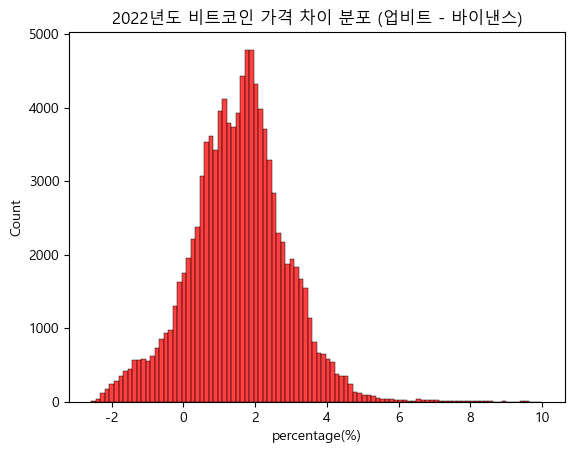

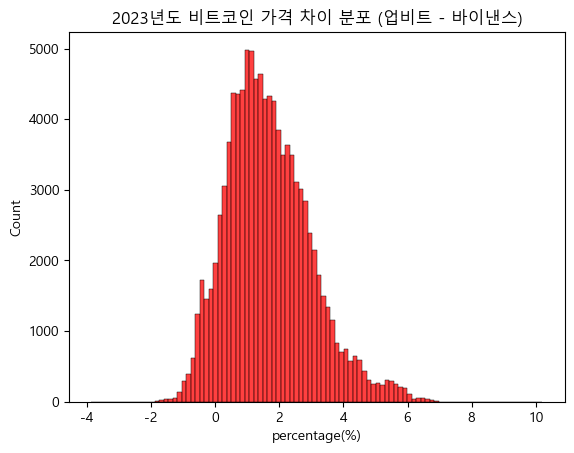

In [21]:
plot_difference(u_b_won_2022, 2022)
plot_difference(u_b_won_2023, 2023)

## 가설검정

### D'Agostino's K-squared

In [22]:
def K_squared_test(data, alpha):
    # D'Agostino's K-squared 검정 수행
    statistic, p_value = normaltest(data)
    
    # 결과 출력
    print(f"D'Agostino's K-squared Test Statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    # 결과 해석
    if p_value < alpha:
        print("귀무 가설을 기각합니다. 데이터가 정규 분포를 따르지 않습니다.")
    else:
        print("귀무 가설을 기각할 수 없습니다. 데이터가 정규 분포를 따릅니다.")

In [23]:
K_squared_test(u_b_won_2022['U'], 0.05)
print()
K_squared_test(u_b_won_2022['B'], 0.05)
print()
K_squared_test(u_b_won_2023['U'], 0.05)
print()
K_squared_test(u_b_won_2023['B'], 0.05)

D'Agostino's K-squared Test Statistic: 836498.4200882595
P-value: 0.0
귀무 가설을 기각합니다. 데이터가 정규 분포를 따르지 않습니다.

D'Agostino's K-squared Test Statistic: 1242354.8434178687
P-value: 0.0
귀무 가설을 기각합니다. 데이터가 정규 분포를 따르지 않습니다.

D'Agostino's K-squared Test Statistic: 9468.353022568795
P-value: 0.0
귀무 가설을 기각합니다. 데이터가 정규 분포를 따르지 않습니다.

D'Agostino's K-squared Test Statistic: 6561.791779650373
P-value: 0.0
귀무 가설을 기각합니다. 데이터가 정규 분포를 따르지 않습니다.


### Wilcoxon's rank sum test
- 데이터가 정규성을 만족하지 않아 비모수적 검정방법을 사용
- 또, 수치에는 의미가 없고 상대적 크기가 의미 있는 경우이므로

In [24]:
def rank_sum_test(u_b_won_):
    # 양측검정
    print("양측검정")
    print(stats.ranksums(u_b_won_['U'], u_b_won_['B'], alternative='two-sided'))
    
    # 단측검정
    print("단측검정")
    print(stats.ranksums(u_b_won_['U'], u_b_won_['B'], alternative='less'))

In [25]:
print(f"{'-'*30}2022년도 순위합 검정{'-'*30}")
rank_sum_test(u_b_won_2022)
print()
print(f"{'-'*30}2023년도 순위합 검정{'-'*30}")
rank_sum_test(u_b_won_2023)

------------------------------2022년도 순위합 검정------------------------------
양측검정
RanksumsResult(statistic=18.801930818051837, pvalue=7.281676763309845e-79)
단측검정
RanksumsResult(statistic=18.801930818051837, pvalue=1.0)

------------------------------2023년도 순위합 검정------------------------------
양측검정
RanksumsResult(statistic=27.047555733435868, pvalue=4.0808859926208076e-161)
단측검정
RanksumsResult(statistic=27.047555733435868, pvalue=1.0)


### 단일 표본 t-검정

In [26]:
# 단일 표본 검정, 모집단의 평균이 0이라고 가정
population_mean = 0

# 단일 표본 t-검정 수행
t_statistic, p_value = ttest_1samp(u_b_won_2023['diff_percentage'], population_mean)

# 결과 출력
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# 결과 해석
alpha = 0.05  # 일반적으로 사용하는 유의 수준

if p_value < alpha:
    print("귀무 가설을 기각합니다. 샘플의 평균이 모집단의 평균과 유의미하게 다릅니다.")
else:
    print("귀무 가설을 기각할 수 없습니다. 샘플의 평균이 모집단의 평균과 유의미하게 다르지 않습니다.")

T-statistic: 411.67363452167194
P-value: 0.0
귀무 가설을 기각합니다. 샘플의 평균이 모집단의 평균과 유의미하게 다릅니다.


## 시각화

In [27]:
def plot_price(u_b_won_, year):
    plt.figure(figsize=(16, 10))
    
    u_b_won_copy = u_b_won_.set_index('datetime')
    u_b_won_copy['U'].plot(label='Upbit')
    u_b_won_copy['B'].plot(label='Binance')
    u_b_won_copy['diff'].plot(label='diff')
    plt.legend()
    plt.ticklabel_format(axis='y',useOffset=False, style='plain')
    plt.xlabel("")
    plt.ylabel("price")
    plt.title(f'<{year}년도 업비트와 바이낸스에서 비트코인 가격 흐름>')
    
    plt.show()

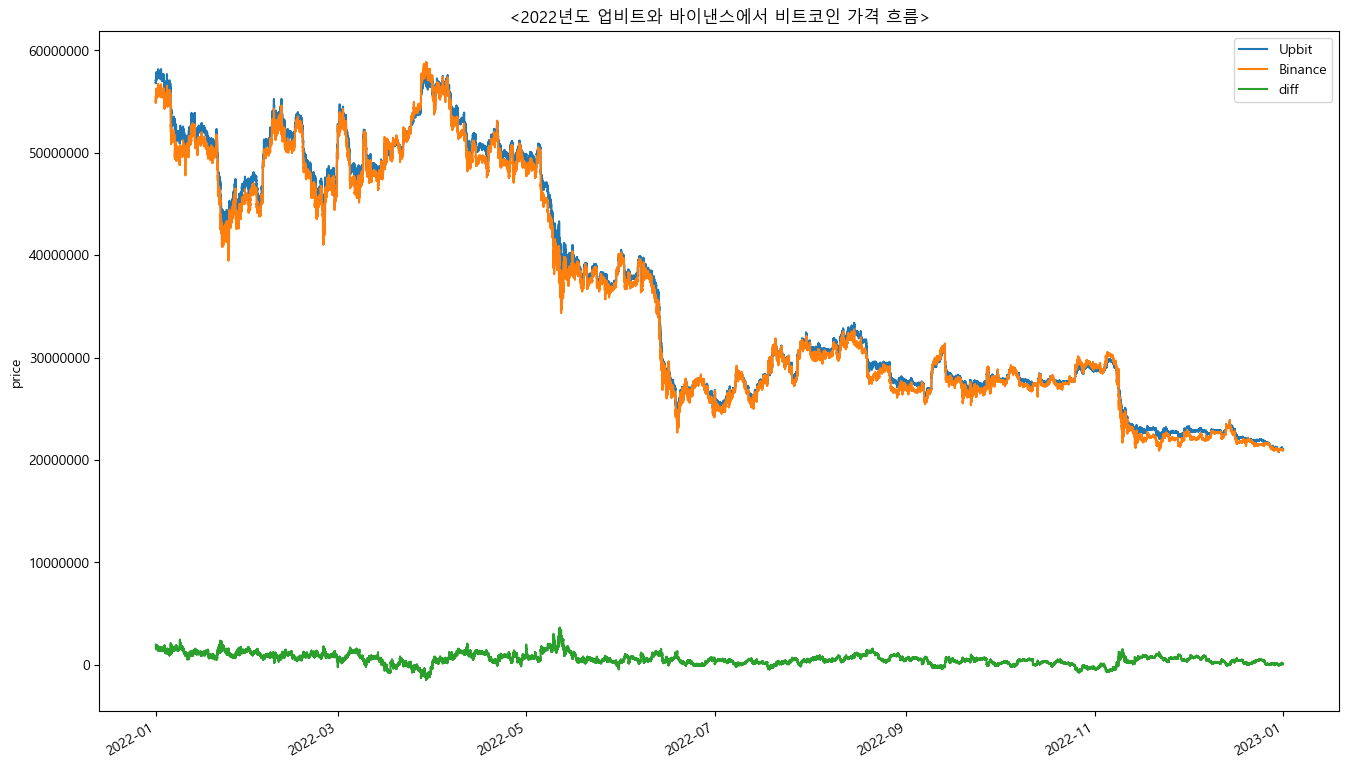

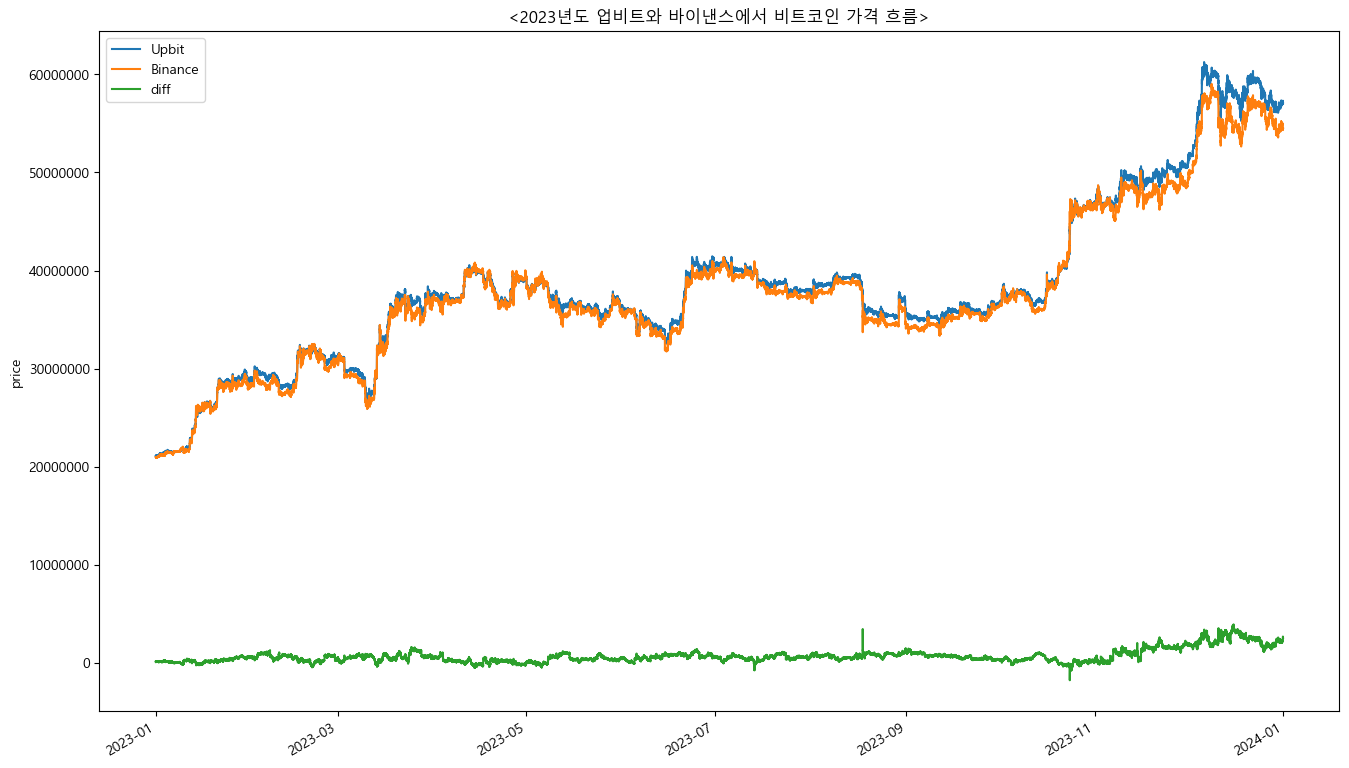

In [28]:
plot_price(u_b_won_2022, 2022)
plot_price(u_b_won_2023, 2023)

In [29]:
def plot_diff(u_b_won_, year):
    plt.figure(figsize=(16, 10))
    
    u_b_won_copy = u_b_won_.set_index('datetime')
    plt.ticklabel_format(axis='y',useOffset=False, style='plain')
    ax = u_b_won_copy['diff_percentage'].plot(label='diff_percentage(%)', color='green')
    
    plt.ylabel("percentage(%)")
    plt.title(f"<{year}년도 거래소간 비트코인 시세차이 (업비트-바이낸스)>")
    plt.legend()
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1.5)  # 빨간색 점선, 두께 1.5
    plt.xlabel("")
    plt.show()

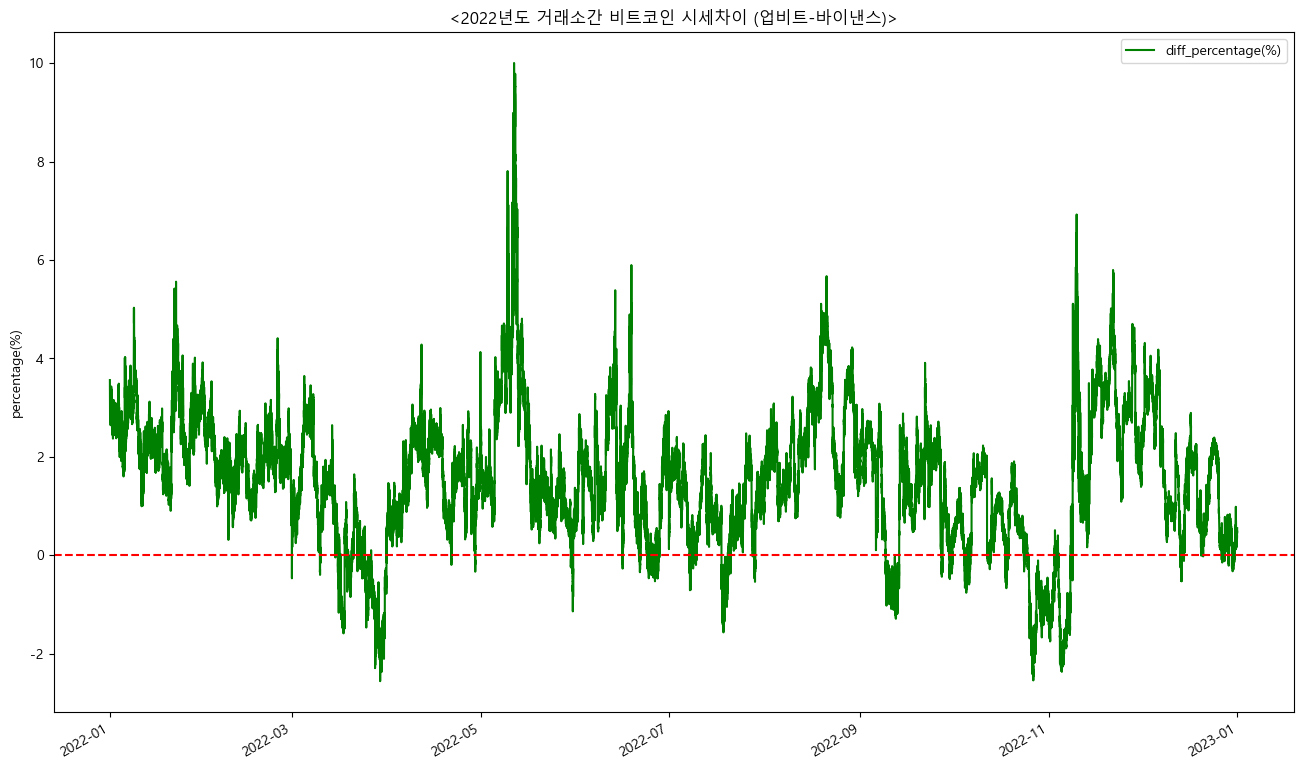

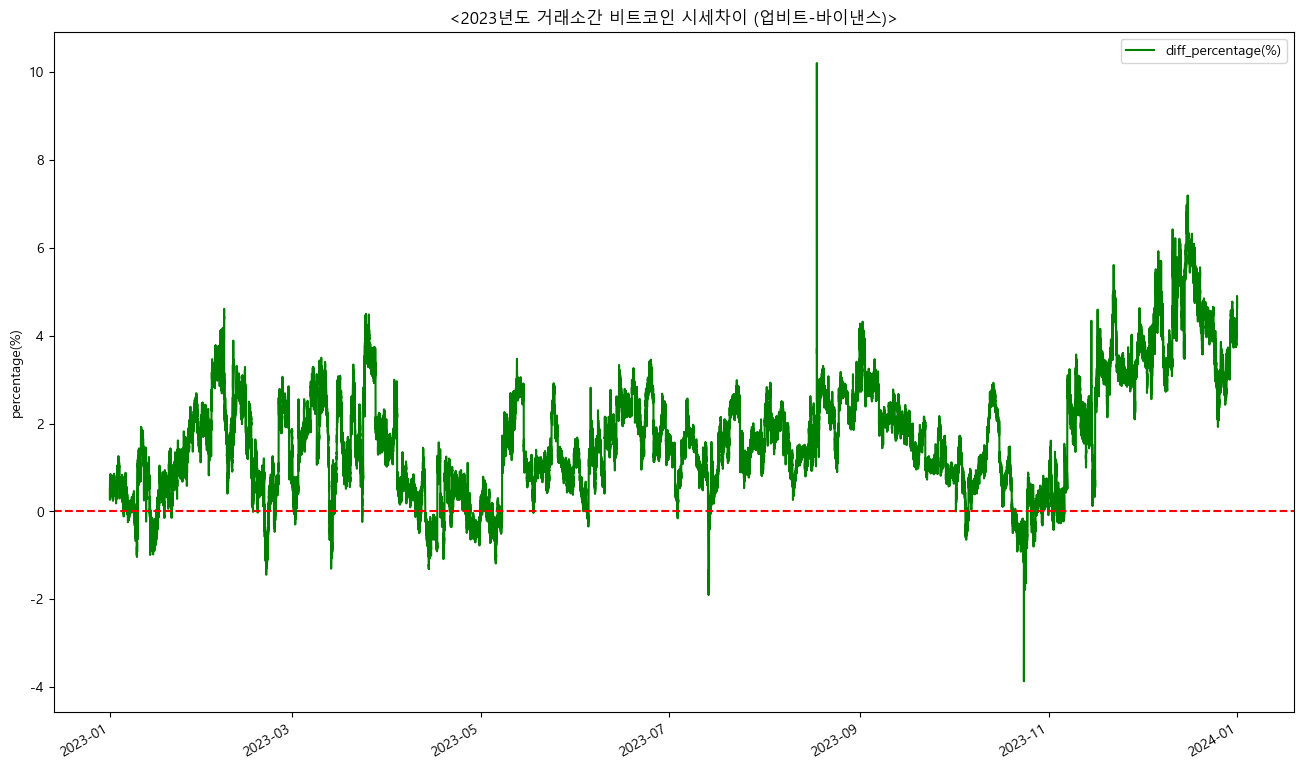

In [30]:
plot_diff(u_b_won_2022, 2022)
plot_diff(u_b_won_2023, 2023)

## 전략 검증

In [31]:
def my_strategy(u_b_won_):
    # 업비트가 바이낸스보다 가격이 낮다면 저평가로 보고 매수, 업비트가 바이낸스보다 높아졌다면 다시 매도를 반복하는 전략의 유효성 평가
    u_b_won_copy = u_b_won_.copy()
    
    u_b_won_copy.loc[u_b_won_copy['diff'] < 0, 'buho'] = '-'
    u_b_won_copy.loc[u_b_won_copy['diff'] >= 0, 'buho'] = '+'
    u_b_won_copy['shift_buho'] = u_b_won_copy['buho'].shift(-1)
    
    u_b_won_copy.loc[(u_b_won_copy['buho'] == '+') & (u_b_won_copy['shift_buho'] == '-'), 'buy_sell'] = 'buy'
    u_b_won_copy.loc[(u_b_won_copy['buho'] == '-') & (u_b_won_copy['shift_buho'] == '+'), 'buy_sell'] = 'sell'
    
    u_b_won_copy['buy_sell'] = u_b_won_copy['buy_sell'].shift()
    
    a = u_b_won_copy.loc[u_b_won_copy['buy_sell'] == 'buy', 'U'].to_frame().rename(columns={'U': 'buy'}).reset_index(drop=True)
    b = u_b_won_copy.loc[u_b_won_copy['buy_sell'] == 'sell', 'U'].to_frame().rename(columns={'U': 'sell'}).reset_index(drop=True)
    
    strategy = pd.concat([a,b], axis=1)
    strategy['profit'] = strategy['sell'] - strategy['buy']
    strategy['profit_rate'] = (strategy['profit'] / strategy['buy']) * 100

    # plot_fv 에 쓰이는 인덱스 정보
    idx = u_b_won_copy.loc[u_b_won_copy['buy_sell'] == 'sell', 'datetime'].tolist()
    idx.insert(0, idx[0])
    idx[0] = idx[1] - pd.Timedelta(minutes=5)
    
    # 바이낸스 공매도
    a = u_b_won_copy.loc[u_b_won_copy['buy_sell'] == 'buy', 'B'].to_frame().rename(columns={'B': 'buy'}).reset_index(drop=True) 
    b = u_b_won_copy.loc[u_b_won_copy['buy_sell'] == 'sell', 'B'].to_frame().rename(columns={'B': 'sell'}).reset_index(drop=True)
    
    strategy2 = pd.concat([a,b], axis=1)
    strategy2['profit'] = strategy2['buy'] - strategy2['sell'] # 공매도 이므로 반대로
    strategy2['profit_rate'] = (strategy2['profit'] / strategy2['sell']) * 100
    
    return idx, strategy, strategy2

In [32]:
idx_2022, strategy_2022, strategy2_2022 = my_strategy(u_b_won_2022)
idx_2023, strategy_2023, strategy2_2023 = my_strategy(u_b_won_2023)

In [33]:
# 단순 홀딩 수익률 흐름(1원을 투자했을 때 잔고)
normal_2022 = u_b_won_2022[['datetime', 'U']].copy()
normal_2022['balance'] = 1 * (normal_2022['U'] / normal_2022['U'].iloc[0])

normal_2023 = u_b_won_2023[['datetime', 'U']].copy()
normal_2023['balance'] = 1 * (normal_2023['U'] / normal_2023['U'].iloc[0])

normal_2023.head()

,datetime,U,balance
0,2023-01-01 00:00:00,21064000.0,1.000000
1,2023-01-01 00:05:00,21040000.0,0.998861
2,2023-01-01 00:10:00,21012000.0,0.997531
3,2023-01-01 00:15:00,21010000.0,0.997436
4,2023-01-01 00:20:00,21048000.0,0.999240


In [34]:
normal_2022 = normal_2022.set_index('datetime').loc[idx_2022]
normal_2023 = normal_2023.set_index('datetime').loc[idx_2023]

In [35]:
def plot_fv(u_b_won_, strategy, strategy2, idx, normal, year):

    # 초기 1원 투자를 가정하므로 행을 하나 추가시킨다.
    # 누적수익률을 계산한다.
    temp = pd.concat([pd.Series([1]), (strategy['profit_rate']/100+1).cumprod()])
    temp.index = idx

    temp2 = pd.concat([pd.Series([1]), (strategy2['profit_rate']/100+1).cumprod()])
    temp2.index = idx
    
    plt.figure(figsize=(10, 6))
    temp.plot(label='balance(upbit)', color='purple')
    temp2.plot(label='balance(binance short selling)', color='brown')
    normal['balance'].plot(label='balance(upbit simple holding)', color='red')
    
    plt.ylabel('balance')
    plt.xlabel("")
    plt.title(f'<{year}년도 김치프리미엄을 이용한 투자 전략 사용시 잔고 변화 (초기 투자 1원)>')
    plt.legend()
    plt.show()

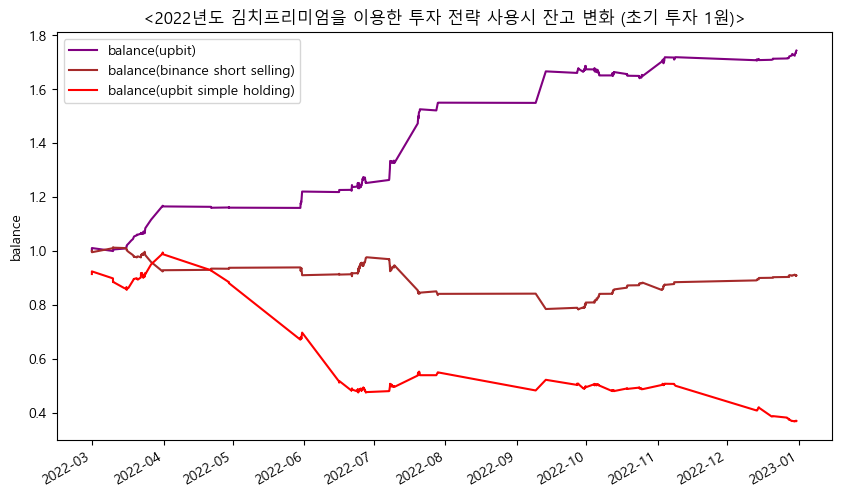

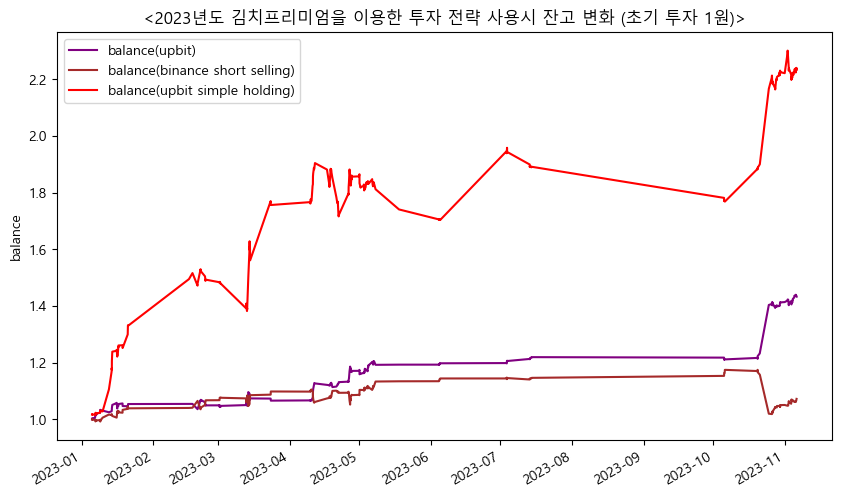

In [36]:
plot_fv(u_b_won_2022, strategy_2022, strategy2_2022, idx_2022, normal_2022, 2022)
plot_fv(u_b_won_2023, strategy_2023, strategy2_2023, idx_2023, normal_2023, 2023)

### strategy1 전략 성과(업비트에서 매수, 매도)

In [37]:
print(((u_b_won_2022['U'].iloc[-1] - u_b_won_2022['U'].iloc[0]) / u_b_won_2022['U'].iloc[0]) * 100) # 단순 홀딩 수익률
print(((u_b_won_2023['U'].iloc[-1] - u_b_won_2023['U'].iloc[0]) / u_b_won_2023['U'].iloc[0]) * 100)

-62.933459942322564
170.8270034181542


In [38]:
print(strategy_2022['profit_rate'].mean()) # 평균 수익률(%)
print(strategy_2023['profit_rate'].mean())

0.14131545401084128
0.09580858009489583


In [39]:
# strategy
print(((1 + strategy_2022['profit_rate']/100).prod() -1) * 100)  # 누적 수익률 2022
print(((1 + strategy_2023['profit_rate']/100).prod() -1) * 100)  # 누적 수익률 2023

74.34123195367638
43.2991386687666


### strategy2 전략 성과(바이낸스에서 공매도)

In [40]:
print(strategy2_2022['profit_rate'].mean()) # 평균 수익률(%)
print(strategy2_2023['profit_rate'].mean())

-0.02062992385740155
0.021085464051416734


In [41]:
# strategy2
# ((1 + strategy2['profit_rate']/100).cumprod() - 1).iloc[-1] # 누적 수익률
print(((1 + strategy2_2022['profit_rate']/100).prod() -1) * 100)  # 누적 수익률 2022
print(((1 + strategy2_2023['profit_rate']/100).prod() -1) * 100)  # 누적 수익률 2023

-9.105009170461509
7.239965296013984
